# Bagging

In [21]:
from preprocessing import *
from aux import *
import matplotlib
#np.warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado 1

In [22]:
columnillas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'amigos', 'parientes', 'precio_ticket', 
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan', 
              'cant_acompañantes']

In [23]:
def preprocesado_1(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = crear_feature_acompañantes(df)
    df = replace_nulls_column(df, 'edad', 'mediana')
    df = encodear_atributos_categoricos(df)
    df = df.reindex(columns = columnas)
    return df

In [24]:
volver = ['volveria']
columnas = columnillas + volver

In [25]:
dataset = pd.merge(df_data, df_decision, how='inner', left_on='id_usuario', right_on='id_usuario')

df = preprocesado_1(dataset, columnas)

df.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes,volveria
0,1,0,0,117,0,0,73.5,0,0,1,0,1,0,0,0
1,1,0,0,658,1,0,35.0,1,1,2,0,1,0,2,0
2,0,1,0,794,0,0,31.0,0,0,3,0,0,0,0,0
3,1,0,0,455,0,0,31.0,0,0,1,1,0,0,0,0
4,1,0,0,173,1,0,4.0,1,1,2,1,0,0,2,1


In [26]:
df.shape

(801, 15)

# Entrenamiento

In [43]:
X, y = split_dataset_X_y(df, columnillas)

params = {'max_samples': np.arange(1, 50), 
          'max_features': np.arange(1, 14),
          'n_estimators': np.arange(1, 50),
         }

model_bagging = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
    random_state = 117
)

best_params, X_train, X_test, y_train, y_test = fit_model_random_grid_search (X, y, model_bagging, params)

bagging = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117,criterion="entropy"),
    random_state=117,
    n_estimators = best_params['n_estimators'],
    max_samples = best_params['max_samples'],
    max_features = best_params['max_features']
)

bagging = apply_stratified_k_fold(X, y, bagging)

X.shape:  (801, 14)
y.shape:  (801,) 

Best score: 0.8268820247134976
Best params {'n_estimators': 31, 'max_samples': 47, 'max_features': 12}

Fold 0: AUC ROC score is 0.7519
Fold 1: AUC ROC score is 0.7962
Fold 2: AUC ROC score is 0.8114
Fold 3: AUC ROC score is 0.7370
Fold 4: AUC ROC score is 0.7482
Mean test AUC ROC is: 0.7689


In [28]:
X.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,117,0,0,73.5,0,0,1,0,1,0,0
1,1,0,0,658,1,0,35.0,1,1,2,0,1,0,2
2,0,1,0,794,0,0,31.0,0,0,3,0,0,0,0
3,1,0,0,455,0,0,31.0,0,0,1,1,0,0,0
4,1,0,0,173,1,0,4.0,1,1,2,1,0,0,2


In [29]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: volveria, dtype: int64

In [30]:
y.sum()

307

In [31]:
y_train.value_counts()

0    367
1    233
Name: volveria, dtype: int64

In [32]:
y_test.value_counts()

0    127
1     74
Name: volveria, dtype: int64

## Métricas

In [33]:
scores = get_scores(bagging, X_test, y_test)

AUC ROC : 0.8622
Accuracy : 0.7861
Precision : 0.7818
Recall : 0.9055
F1-Score : 0.6667


### Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


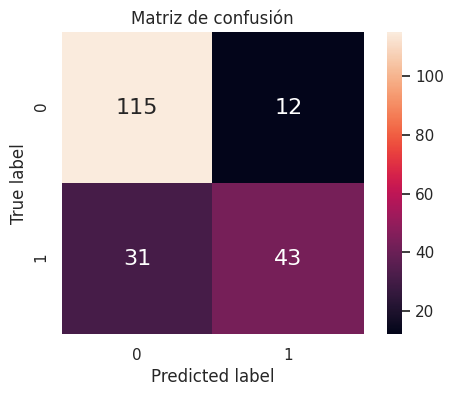

In [34]:
plot_confusion_matrix(y_test, bagging.predict(X_test))

## Test Holdout

In [35]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')

In [36]:
df_h = preprocesado_1(holdout, columnillas)
df_h.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,650,1,0,26.0,0,0,1,1,0,0,0
1,1,0,0,234,1,0,8.0,4,2,4,1,0,0,6
2,0,1,0,31,0,0,43.0,0,0,3,0,0,0,0
3,0,0,0,552,0,0,30.0,0,0,3,1,0,0,0
4,1,0,0,411,0,0,32.0,0,0,1,1,0,0,0


In [37]:
df_resultado = evaluate_holdout(holdout, df_h, bagging)
df_resultado.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 14) 



,id_usuario,volveria
0,650,0
1,234,1
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,0
9,112,1


In [38]:
df_resultado.to_csv('prediccion/Bagging_resultado_final.csv')

## Preprocesado 2

In [71]:
columnas_2 = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad',
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan']

In [72]:
def preprocesado_2(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = replace_nulls_column(df, 'edad', 'media')
    df = eliminar_feature(df, 'precio_ticket')
    df = eliminar_feature(df, 'amigos')
    df = eliminar_feature(df, 'parientes')
    df = encodear_atributos_categoricos(df)
    df = df.reindex(columns = columnas)
    return df

In [73]:
df_2 = preprocesado_2(dataset, columnas_2+volver)

df_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,volveria
0,1,0,0,117,0,0,73.5,0,1,0,0
1,1,0,0,658,1,0,35.0,0,1,0,0
2,0,1,0,794,0,0,32.7,0,0,0,0
3,1,0,0,455,0,0,32.7,1,0,0,0
4,1,0,0,173,1,0,4.0,1,0,0,1


In [74]:
df_2.shape

(801, 11)

# Entrenamiento

In [77]:
X_2, y_2 = split_dataset_X_y(df_2, columnas_2)

model_bagging = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
    random_state = 117
)
params_2 = {'max_samples': np.arange(1, 50), 
          'max_features': np.arange(1, 10),
          'n_estimators': np.arange(1, 50),
         }
best_params_2, X_train_2, X_test_2, y_train_2, y_test_2 = fit_model_random_grid_search (X_2, y_2, model_bagging,
                                                                                        params_2)

bagging_2 = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117,criterion="entropy"),
    random_state=117,
    n_estimators = best_params_2['n_estimators'],
    max_samples = best_params_2['max_samples'],
    max_features = best_params_2['max_features']
)

bagging_2 = apply_stratified_k_fold(X_2, y_2, bagging_2)

X.shape:  (801, 10)
y.shape:  (801,) 

Best score: 0.8396514327615667
Best params {'n_estimators': 14, 'max_samples': 47, 'max_features': 7}

Fold 0: AUC ROC score is 0.7660
Fold 1: AUC ROC score is 0.7711
Fold 2: AUC ROC score is 0.8114
Fold 3: AUC ROC score is 0.7370
Fold 4: AUC ROC score is 0.7860
Mean test AUC ROC is: 0.7743


## Métricas

In [78]:
scores_2 = get_scores(bagging_2, X_test_2, y_test_2)

AUC ROC : 0.8716
Accuracy : 0.8408
Precision : 0.9200
Recall : 0.9685
F1-Score : 0.7419


### Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


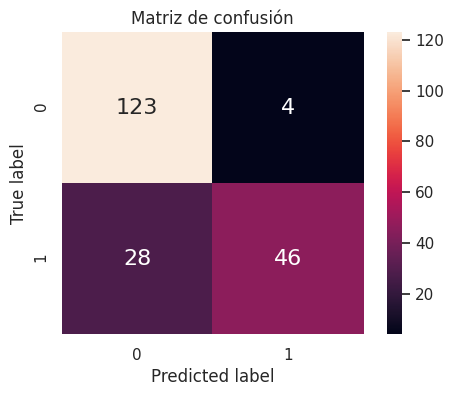

In [79]:
plot_confusion_matrix(y_test_2, bagging_2.predict(X_test_2))

## Test Holdout

In [80]:
df_h_2 = preprocesado_2(holdout, columnas_2)
df_h_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,1,0,0,650,1,0,26.0,1,0,0
1,1,0,0,234,1,0,8.0,1,0,0
2,0,1,0,31,0,0,43.0,0,0,0
3,0,0,0,552,0,0,30.0,1,0,0
4,1,0,0,411,0,0,32.8,1,0,0


In [81]:
df_resultado_2 = evaluate_holdout(holdout, df_h_2, bagging_2)
df_resultado_2.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 10) 



,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,0
9,112,1


In [82]:
df_resultado_2.to_csv('prediccion/Bagging_2do_prepoc_resultado_final.csv')